In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_final_labels import labels as coco_labels
from coco_final_labels_transfer import labels as coco_labels_transfer
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
import random
import tensorflow_addons as tfa
import io

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2022-08-04 19:54:38.943931: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-08-04 19:54:38.943967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: BOSQNUX
2022-08-04 19:54:38.943974: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: BOSQNUX
2022-08-04 19:54:38.944109: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.85.2
2022-08-04 19:54:38.944132: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-08-04 19:54:38.944137: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.73.5 does not match DSO version 510.85.2 -- cannot find working devices in this configuration


In [2]:
LAST_DENSE = 1024
SOFTMAX_OUT = True
FROM_LOGITS = False
LEARNING_RATE = 0.0001
INFO = "-"
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'
TRANSFER_TRAIN_IMAGES ='data/transfer_train'
TRANSFER_VAL_IMAGES = 'data/transfer_val'
BATCH_SIZE = 16

CONFIG_STRING = "batch_size: {0} | last_dense: {1} | softmax: {2} | from_logits: {3} | lr: {4} | info: {5}"

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2022-08-07 13:12:34.626912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 13:12:34.632280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 13:12:34.632434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 13:12:34.632939: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

print(len(val_files))

transfer_train_files = {}
for d in os.listdir(TRANSFER_TRAIN_IMAGES):
    files = os.listdir(f"{TRANSFER_TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        transfer_train_files[d] = files

print(len(transfer_train_files))

transfer_val_files = {}
for d in os.listdir(TRANSFER_VAL_IMAGES):
    files = os.listdir(f"{TRANSFER_VAL_IMAGES}/{d}")
    if len(files) > 0:
        transfer_val_files[d] = files

print(len(transfer_val_files))

80
80
6
6


In [11]:
def load_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image

def preprocess_triplets(images,labels):
    anchor = load_image(images[0])
    positive = load_image(images[1])
    negative = load_image(images[2])
    return ((anchor, positive, negative), labels)

def preprocess_image_label(image, label):
    img = load_image(image)
    return (img, label)

def get_training_triplets(include_transfer: bool=False):
    X_a = []
    X_p = []
    X_n = []

    Y_a = []
    Y_p = []
    Y_n = []
    
    labels = coco_labels if not include_transfer else coco_labels_transfer
    filepool = train_files if not include_transfer else {**train_files, **transfer_train_files}

    for i in range(2**18):
        c = random.choice(labels)
        n = random.choice([d for d in labels if d is not c])
        anchor = random.choice(filepool[c])
        positive = random.choice(filepool[c])
        negative = random.choice(filepool[n])

        if c in coco_labels:
            X_a.append(f"{TRAIN_IMAGES}/{c}/{anchor}")
            X_p.append(f"{TRAIN_IMAGES}/{c}/{positive}")
        else:
            X_a.append(f"{TRANSFER_TRAIN_IMAGES}/{c}/{anchor}")
            X_p.append(f"{TRANSFER_TRAIN_IMAGES}/{c}/{positive}")

        if n in coco_labels:
            X_n.append(f"{TRAIN_IMAGES}/{n}/{negative}")
        else:
            X_n.append(f"{TRANSFER_TRAIN_IMAGES}/{n}/{negative}")

        Y_a.append(labels.index(c))
        Y_p.append(labels.index(c))
        Y_n.append(labels.index(n))

    t_data = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(X_a),
        tf.data.Dataset.from_tensor_slices(X_p),
        tf.data.Dataset.from_tensor_slices(X_n)
    ))

    t_labels = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(Y_a),
        tf.data.Dataset.from_tensor_slices(Y_p),
        tf.data.Dataset.from_tensor_slices(Y_n)
    ))

    return tf.data.Dataset.zip((t_data, t_labels)).map(preprocess_triplets).batch(32)

def get_validation_triplets(include_transfer:bool=False):
    X_a = []
    X_p = []
    X_n = []

    Y_a = []
    Y_p = []
    Y_n = []

    labels = coco_labels if not include_transfer else coco_labels_transfer
    filepool = val_files if not include_transfer else {**val_files, **transfer_val_files}

    for i in range(2**12):
        c = random.choice(labels)
        n = random.choice([d for d in labels if d is not c])
        anchor = random.choice(filepool[c])
        positive = random.choice(filepool[c])
        negative = random.choice(filepool[n])

        if c in coco_labels:
            X_a.append(f"{VAL_IMAGES}/{c}/{anchor}")
            X_p.append(f"{VAL_IMAGES}/{c}/{positive}")
        else:
            X_a.append(f"{TRANSFER_VAL_IMAGES}/{c}/{anchor}")
            X_p.append(f"{TRANSFER_VAL_IMAGES}/{c}/{positive}")

        if n in coco_labels:
            X_n.append(f"{VAL_IMAGES}/{n}/{negative}")
        else:
            X_n.append(f"{TRANSFER_VAL_IMAGES}/{n}/{negative}")

        Y_a.append(labels.index(c))
        Y_p.append(labels.index(c))
        Y_n.append(labels.index(n))

    t_data = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(X_a),
        tf.data.Dataset.from_tensor_slices(X_p),
        tf.data.Dataset.from_tensor_slices(X_n)
    ))

    t_labels = tf.data.Dataset.zip((
        tf.data.Dataset.from_tensor_slices(Y_a),
        tf.data.Dataset.from_tensor_slices(Y_p),
        tf.data.Dataset.from_tensor_slices(Y_n)
    ))

    return tf.data.Dataset.zip((t_data, t_labels)).map(preprocess_triplets).batch(32)

def get_validation_dataset(include_transfer: bool=False, include_transfer_train: bool=False):
    X = []
    Y = []

    for c in coco_labels:
        for file in val_files[c]:
            anchor = file
            X.append(f"{VAL_IMAGES}/{c}/{anchor}")
            Y.append(coco_labels.index(c))

    if include_transfer:
        for c in [x for x in coco_labels_transfer if x not in coco_labels]:
            for file in transfer_val_files[c]:
                anchor = file
                X.append(f"{TRANSFER_VAL_IMAGES}/{c}/{anchor}")
                Y.append(coco_labels_transfer.index(c))

    if include_transfer_train:
        for c in [x for x in coco_labels_transfer if x not in coco_labels]:
            for file in transfer_train_files[c]:
                anchor = file
                X.append(f"{TRANSFER_TRAIN_IMAGES}/{c}/{anchor}")
                Y.append(coco_labels_transfer.index(c))

    a = tf.data.Dataset.from_tensor_slices(X)
    b = tf.data.Dataset.from_tensor_slices(Y)
    final_data = tf.data.Dataset.zip((a,b))
    processed_data = final_data.map(preprocess_image_label)
    return processed_data

In [12]:
data = get_training_triplets()
val_data = get_validation_triplets()
val_ds = get_validation_dataset().batch(32)

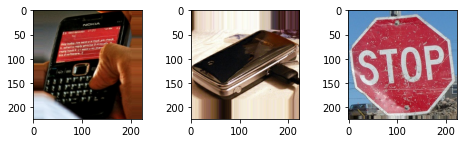

In [23]:
fig = plt.pyplot.figure(figsize=(8,2))
axs = fig.subplots(1,3)

img_batch = next(data.as_numpy_iterator())

anchors_viz = img_batch[0][0][2]
positives_viz = img_batch[0][1][2]
negatives_viz = img_batch[0][2][2]

axs[0].imshow(anchors_viz)
axs[1].imshow(positives_viz)
axs[2].imshow(negatives_viz)

In [3]:
resnet50 = keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet50.trainable = True

In [6]:

input = Input(shape=(224,224,3), name="resnet50v2_model")
encoder = resnet50(input)
avg_pool = GlobalAveragePooling2D()(encoder)
fc = Dense(2048, activation="relu")(avg_pool)
fc = Dense(1024, activation="relu")(fc)
fc = Dense(256, activation=None)(fc)
model = Model(input, fc, name="ResNet50v2")


model.summary()

Model: "ResNet50v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2_model (InputLaye  [(None, 224, 224, 3)]    0         
 r)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 256)               2

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 pos_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 neg_input (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                          

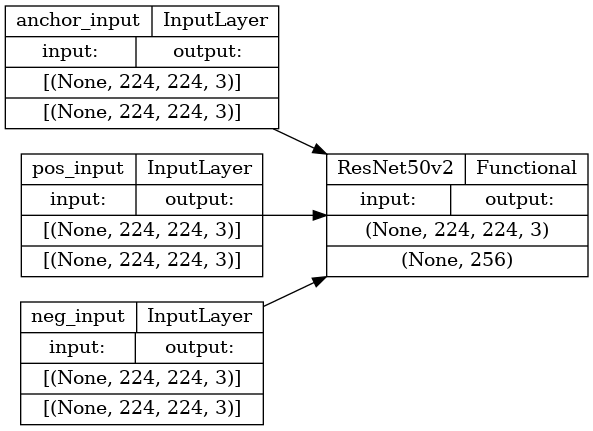

In [24]:
anchor_input = Input(shape=(224,224,3), name="anchor_input")
positive_input = Input(shape=(224,224,3), name="pos_input")
negative_input = Input(shape=(224,224,3), name="neg_input")

embedding_model = model

encoded_anchor = embedding_model(anchor_input)
encoded_positive = embedding_model(positive_input)
encoded_negative = embedding_model(negative_input)

inputs = [anchor_input, positive_input, negative_input]
outputs = [encoded_anchor, encoded_positive, encoded_negative]

siamese_triplet = tf.keras.Model(inputs=inputs, outputs=outputs)

siamese_triplet.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss=tfa.losses.TripletHardLoss()
)

siamese_triplet.summary()

tf.keras.utils.plot_model(siamese_triplet, to_file="logs/siamese_tripletloss/siamese_model.png", show_shapes=True, expand_nested=False, rankdir='LR')

In [26]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/siamese_tripletloss

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/siamese_tripletloss/{0}'.format(current_time)
weight_dir = 'weights/siamese_tripletloss/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=20)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

class ClusteringCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        results = embedding_model.predict(val_ds)
        np.savetxt(f"{log_dir}/vecs_{epoch}.tsv", results, delimiter='\t')

        out_m = io.open(f"{log_dir}/meta_{epoch}.tsv", "w", encoding="utf-8")
        for img, labels in tfds.as_numpy(val_ds):
            [out_m.write(str(x) + "\n") for x in labels]
        out_m.close()

clustering_callback = ClusteringCallback()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 443202), started 0:00:03 ago. (Use '!kill 443202' to kill it.)

In [13]:
siamese_triplet.fit(data, validation_data=val_data, epochs=40, steps_per_epoch=200, batch_size=32, callbacks=[tensorboard_callback, weight_callback, clustering_callback])

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 1.3534 - model_loss: 0.4630 - model_1_loss: 0.4496 - model_2_loss: 0.4408

2022-08-04 20:16:52.416614: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights/siamese_tripletloss/20220804-195539/assets
100/100 [==============================] - 1614s 16s/step - loss: 1.3534 - model_loss: 0.4630 - model_1_loss: 0.4496 - model_2_loss: 0.4408 - val_loss: 1.1482 - val_model_loss: 0.3876 - val_model_1_loss: 0.3674 - val_model_2_loss: 0.3932
Epoch 2/40
100/100 [==============================] - 1587s 16s/step - loss: 1.1167 - model_loss: 0.3667 - model_1_loss: 0.3623 - model_2_loss: 0.3878 - val_loss: 1.0461 - val_model_loss: 0.3493 - val_model_1_loss: 0.3440 - val_model_2_loss: 0.3528
Epoch 3/40
100/100 [==============================] - 1580s 16s/step - loss: 1.0405 - model_loss: 0.3543 - model_1_loss: 0.3417 - model_2_loss: 0.3445 - val_loss: 0.9641 - val_model_loss: 0.3190 - val_model_1_loss: 0.3151 - val_model_2_loss: 0.3301
Epoch 4/40
100/100 [==============================] - 1589s 16s/step - loss: 0.9271 - model_loss: 0.3088 - model_1_loss: 0.3208 - model_2_loss: 0.2975 - val_loss: 0.8978 - val_mo

In [115]:
embedding_model.save(os.path.join(weight_dir, "final_embedding"))

INFO:tensorflow:Assets written to: weights/siamese_tripletloss/20220804-195539/final_embedding/assets


In [162]:
embedding_model = tf.keras.models.load_model('weights/siamese_tripletloss/20220804-195539/final_embedding')

In [71]:

iter = val_data.as_numpy_iterator()
img_batch = next(iter)

0.1531047821044922
0.7030476629734039


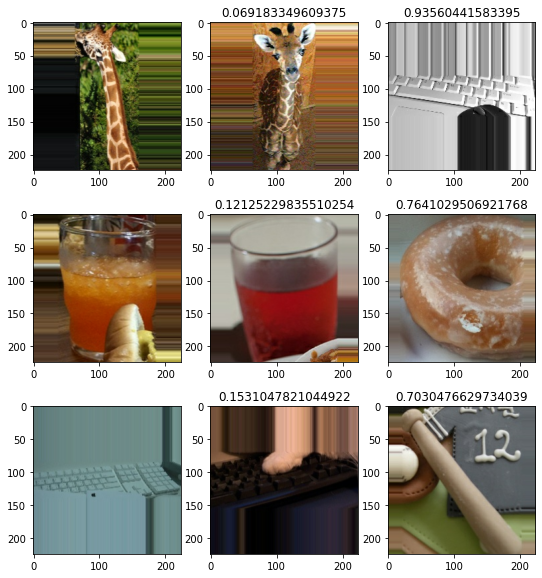

In [72]:
from scipy.spatial import distance

fig = plt.pyplot.figure(figsize=(9,10))
axs = fig.subplots(3,3)

anchors_viz = img_batch[0][0][:3]
positives_viz = img_batch[0][1][:3]
negatives_viz = img_batch[0][2][:3]

anchor_embeds = embedding_model.predict(anchors_viz)
pos_embeds = embedding_model.predict(positives_viz)
neg_embeds = embedding_model.predict(negatives_viz)

print(distance.cosine(anchor_embeds[2], pos_embeds[2]))
print(distance.cosine(anchor_embeds[2], neg_embeds[2]))

axs[0, 1].set_title(str(distance.cosine(anchor_embeds[0], pos_embeds[0])))
axs[0, 2].set_title(str(distance.cosine(anchor_embeds[0], neg_embeds[0])))

axs[1, 1].set_title(str(distance.cosine(anchor_embeds[1], pos_embeds[1])))
axs[1, 2].set_title(str(distance.cosine(anchor_embeds[1], neg_embeds[1])))

axs[2, 1].set_title(str(distance.cosine(anchor_embeds[2], pos_embeds[2])))
axs[2, 2].set_title(str(distance.cosine(anchor_embeds[2], neg_embeds[2])))

for i in range(3):
    axs[0, i].imshow(img_batch[0][i][0])
    axs[1, i].imshow(img_batch[0][i][1])
    axs[2, i].imshow(img_batch[0][i][2])


In [74]:
MAX_ANCHORS = 16

import shutil


for dir in os.listdir(TRAIN_IMAGES):
    count = 0
    for file in os.listdir(os.path.join(TRAIN_IMAGES, dir)):
        c = dir

        if not os.path.exists(f'data/siamese_anchors_tripletloss/{c}'):
            os.mkdir(f'data/siamese_anchors_tripletloss/{c}')

        shutil.copyfile(os.path.join(TRAIN_IMAGES, dir, file), f'data/siamese_anchors_tripletloss/{c}/{file}')
        count += 1

        print(count)

        if count >= MAX_ANCHORS:
            break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1
2
3
4
5
6
7
8
9
10
11
1

In [89]:

anchor_averages = []
for i,c in enumerate(coco_labels):
    print(i)
    anchs = []

    for image in os.listdir(f'data/siamese_anchors_tripletloss/{c}'):
        img = load_image(f'data/siamese_anchors_tripletloss/{c}/{image}')
        anchs.append(img)

    preds = embedding_model.predict(np.array(anchs).reshape(16,224,224,3))
    anchor_averages.append(np.average(preds, axis=0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [109]:
iter = val_ds.as_numpy_iterator()

f = open("logs/siamese_tripletloss/predictions.txt", "w")

for imgs,lbls in iter:
    preds = embedding_model.predict(imgs)

    for y,pred in enumerate(preds):
        distances = []
        for i,anchor in enumerate(anchor_averages):
            dist = distance.cosine(anchor, pred)
            distances.append(dist)

        guess = np.argmin(np.array(distances))
        f.write(f'{lbls[y]}:{guess}:{file}\n')

f.close()

In [138]:
import itertools
def plot_confusion_matrix(cm, class_names, filename):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    plt.pyplot.rcParams.update({'font.size': 10})
    figure = plt.pyplot.figure(figsize=(30, 30))
    plt.pyplot.imshow(cm, interpolation='nearest', cmap=plt.pyplot.cm.Blues)
    plt.pyplot.title("Confusion matrix")
    plt.pyplot.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.pyplot.xticks(tick_marks, class_names, rotation=90)
    plt.pyplot.yticks(tick_marks, class_names)
    
    cm = np.array(cm)
    cm = np.nan_to_num(0)
    # Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=0)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    # threshold = cm.max() / 2.
    
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     color = "white" if cm[i, j] > threshold else "black"
    #     plt.pyplot.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.pyplot.tight_layout()
    plt.pyplot.ylabel('True label')
    plt.pyplot.xlabel('Predicted label')
    plt.pyplot.savefig(filename)
    return figure

/tmp/ipykernel_319120/3013227483.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=0)


[[0.48349057 0.         0.         ... 0.         0.00561798 0.00273973]
 [0.         0.47058824 0.         ... 0.         0.         0.        ]
 [0.         0.         0.33333333 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.16666667 ... 0.78947368 0.         0.        ]
 [0.         0.05882353 0.         ... 0.         0.71348315 0.00273973]
 [0.         0.         0.         ... 0.         0.01123596 0.75068493]]


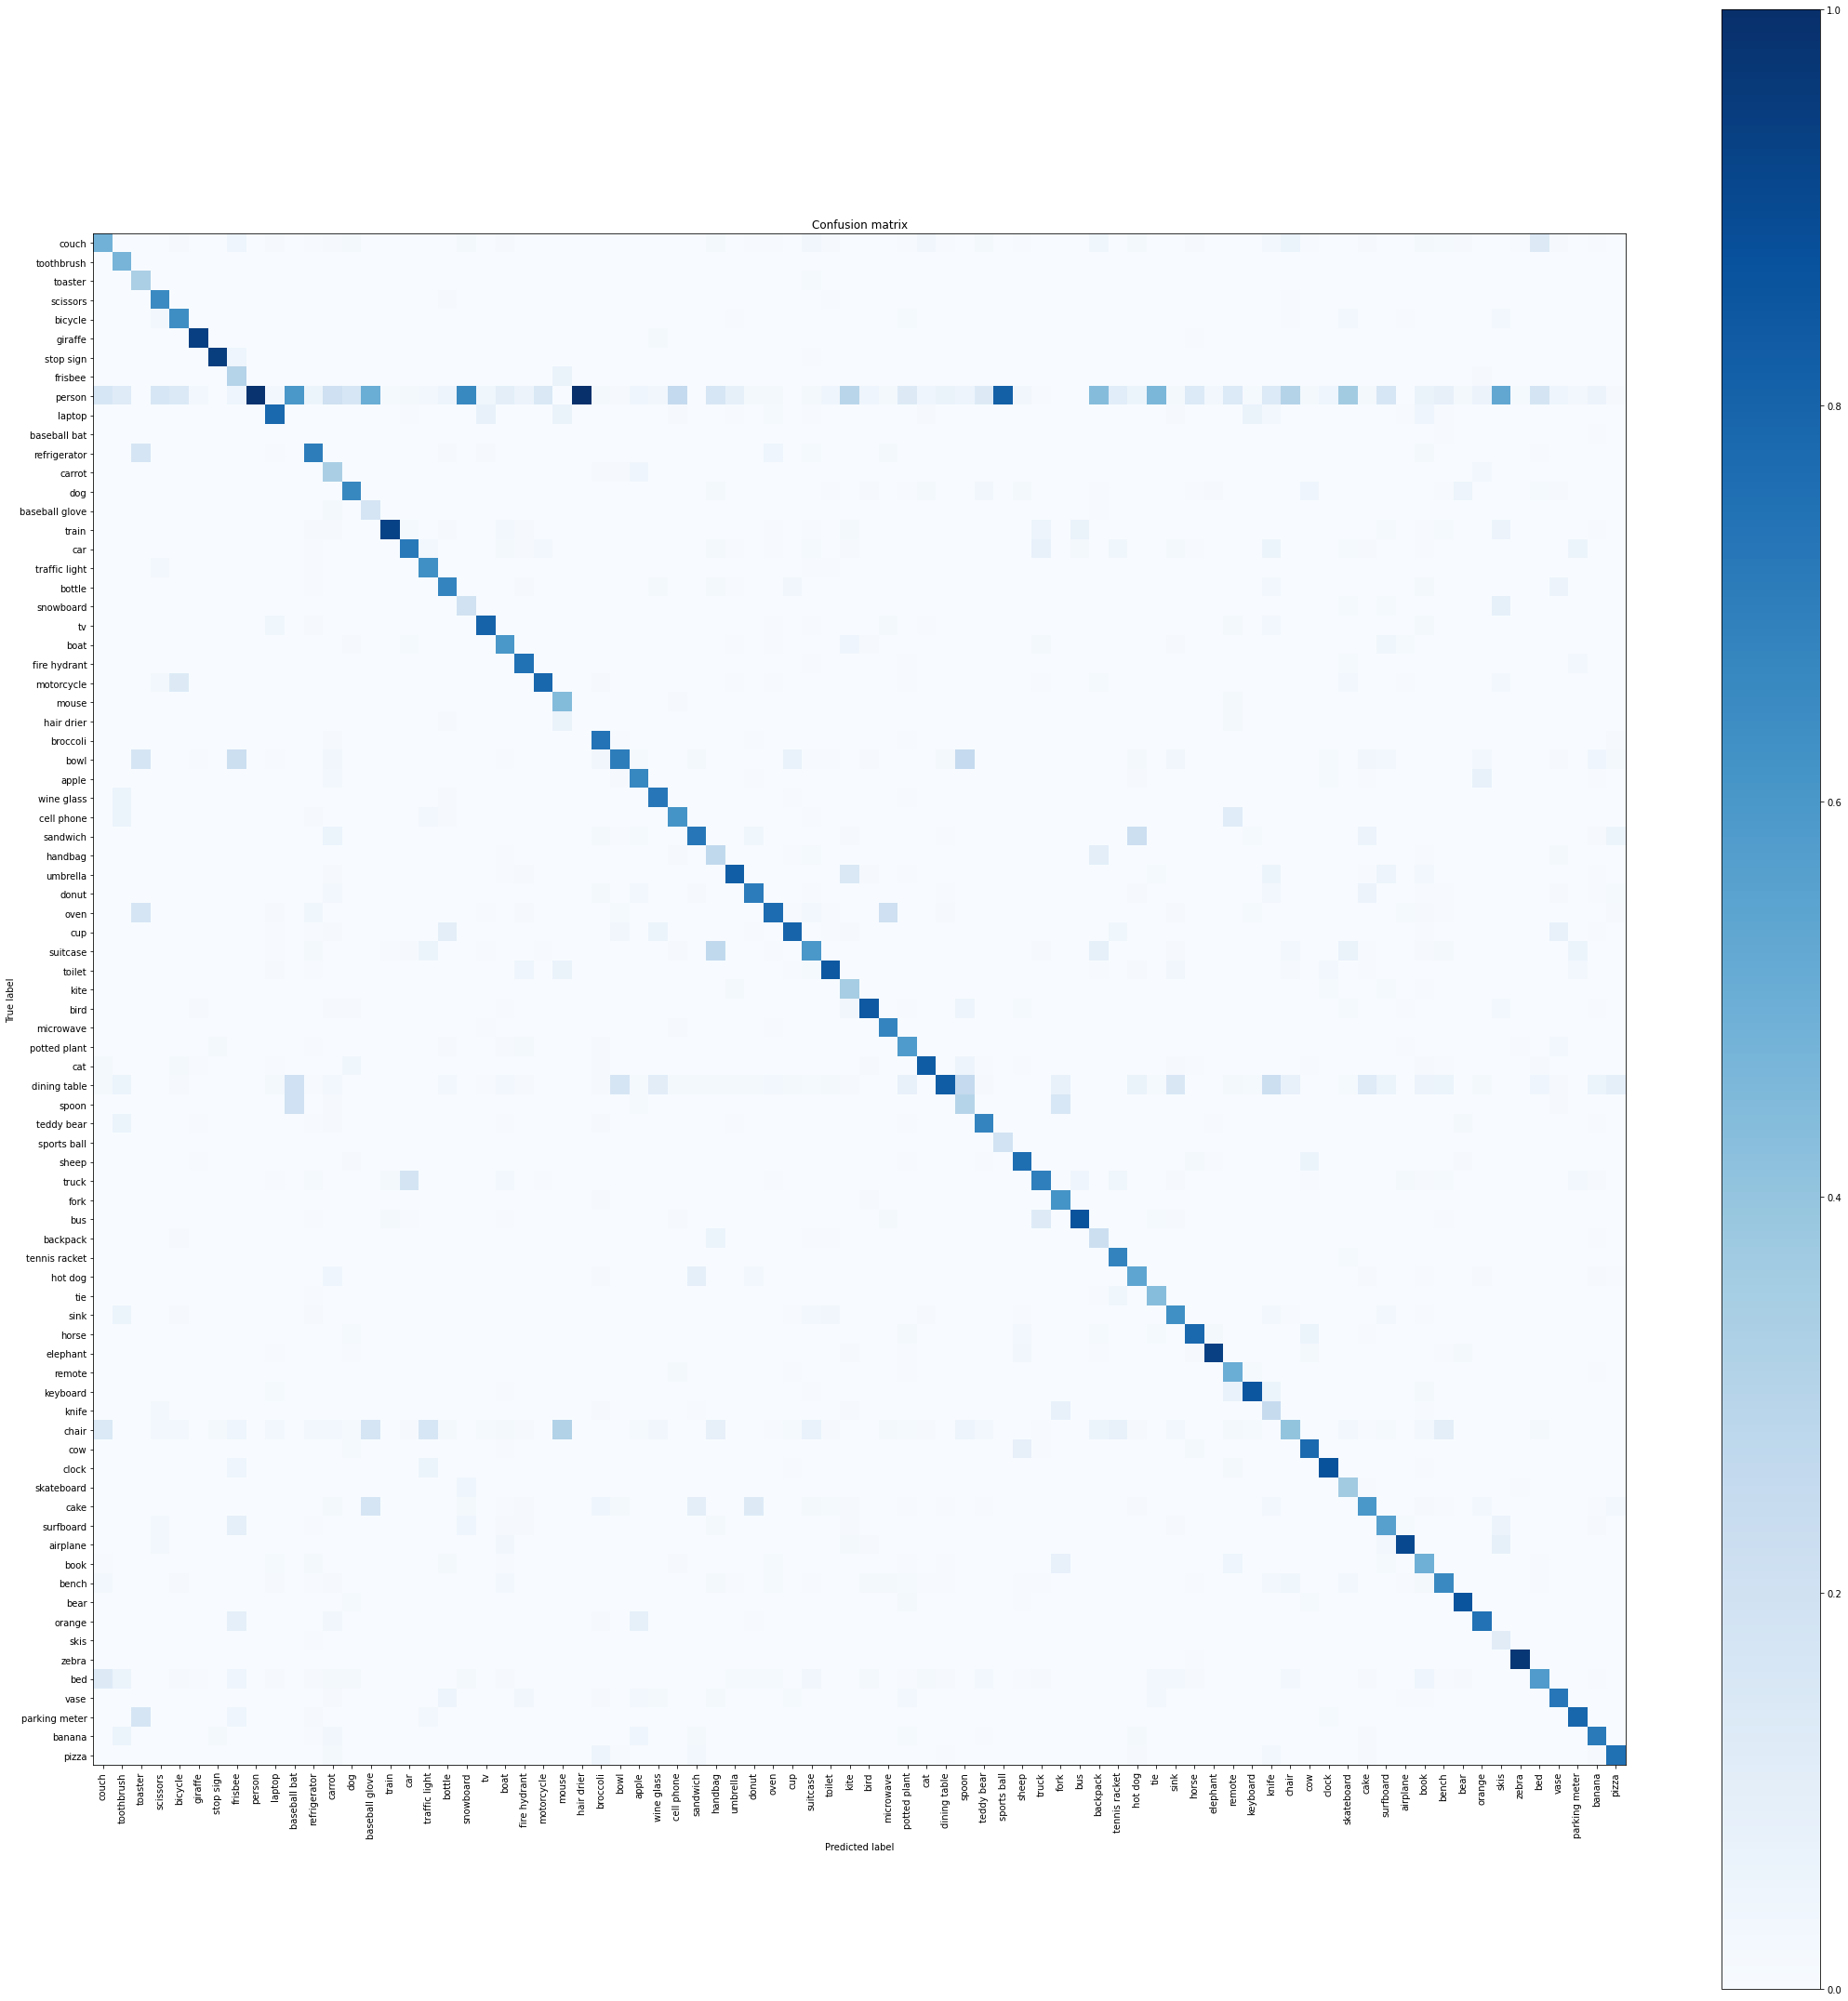

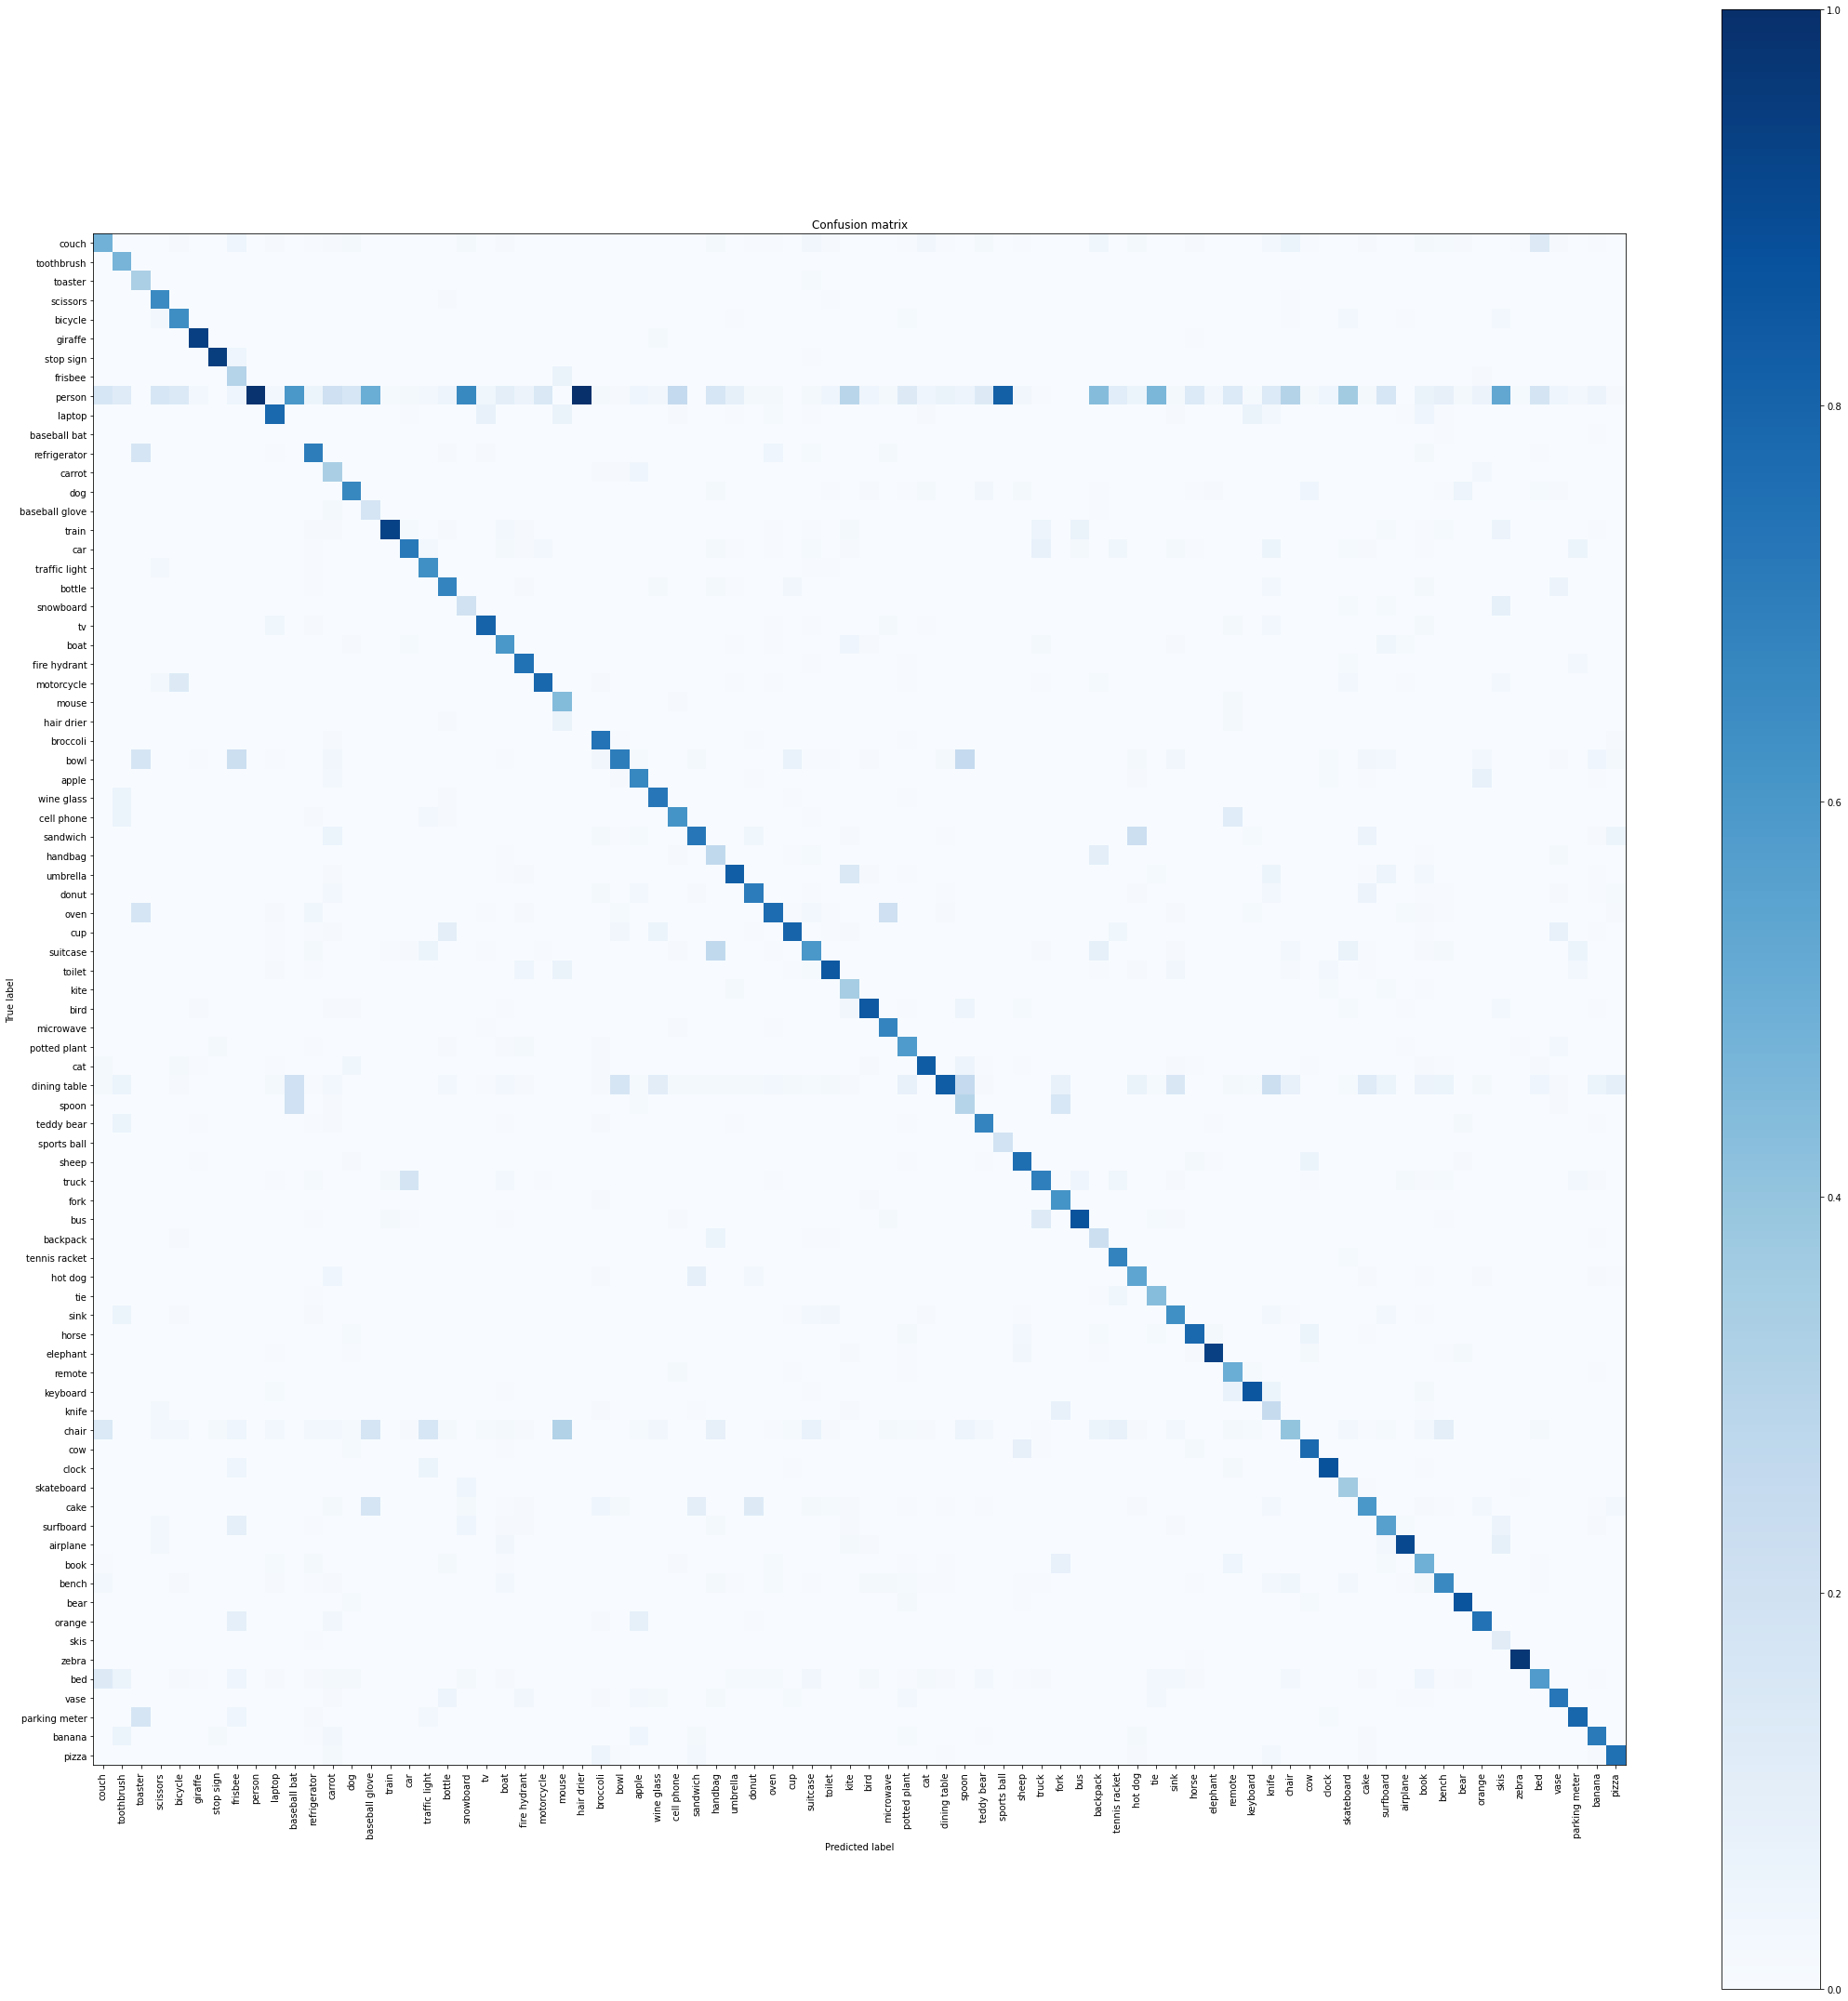

In [117]:
y = []
yhat = []

with open("logs/siamese_tripletloss/predictions.txt") as f:
    while True:
        line = f.readline()
        if line == "":
            break
        split = line.split(':')
        y.append(int(split[0]))
        yhat.append(int(split[1]))



cm = np.array(tf.math.confusion_matrix(np.array(y), np.array(yhat)))
cm = cm / cm.astype(np.float).sum(axis=0)
print(cm)

plot_confusion_matrix(cm, coco_labels, 'logs/siamese_tripletloss/siamese-confusionmatrix.jpg')

In [120]:
tp = 0
fp = 0

for i in range(len(y)):
    if y[i] == yhat[i]:
        tp += 1
    else:
        fp += 1

print(f"True positives: {tp}, False positives: {fp}, Precision: {tp/(tp+fp)}")

True positives: 12437, False positives: 3568, Precision: 0.7770696657294596


In [133]:
transfer_val_ds = get_validation_dataset(include_transfer=True, include_transfer_train=True).batch(32)

results = embedding_model.predict(transfer_val_ds)
np.savetxt(f"{log_dir}/vecs_initial_transfer.tsv", results, delimiter='\t')

out_m = io.open(f"{log_dir}/meta_initial_transfer.tsv", "w", encoding="utf-8")
for img, labels in tfds.as_numpy(transfer_val_ds):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

In [134]:
shutil.copytree('data/siamese_anchors_tripletloss', 'data/siamese_anchors_tripletloss_transfer/')

for dir in os.listdir(TRANSFER_TRAIN_IMAGES):
    count = 0
    for file in os.listdir(os.path.join(TRANSFER_TRAIN_IMAGES, dir)):
        c = dir

        if not os.path.exists(f'data/siamese_anchors_tripletloss_transfer/{c}'):
            os.mkdir(f'data/siamese_anchors_tripletloss_transfer/{c}')

        shutil.copyfile(os.path.join(TRANSFER_TRAIN_IMAGES, dir, file), f'data/siamese_anchors_tripletloss_transfer/{c}/{file}')
        count += 1

        print(count)

        if count >= MAX_ANCHORS:
            break

1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8


In [163]:
transfer_anchor_averages = []
for i,c in enumerate(coco_labels_transfer):
    print(i)
    anchs = []

    for image in os.listdir(f'data/siamese_anchors_tripletloss_transfer/{c}'):
        img = load_image(f'data/siamese_anchors_tripletloss_transfer/{c}/{image}')
        anchs.append(img)

    preds = embedding_model.predict(np.array(anchs).reshape(len(anchs),224,224,3))
    transfer_anchor_averages.append(np.average(preds, axis=0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


In [164]:
iter = transfer_val_ds.as_numpy_iterator()

f = open("logs/siamese_tripletloss/predictions_transfer_initial2.txt", "w")

for imgs,lbls in iter:
    preds = embedding_model.predict(imgs)

    for y,pred in enumerate(preds):
        distances = []
        for i,anchor in enumerate(transfer_anchor_averages):
            dist = distance.cosine(anchor, pred)
            distances.append(dist)

        guess = np.argmin(np.array(distances))
        f.write(f'{lbls[y]}:{guess}:{file}\n')

f.close()

/tmp/ipykernel_319120/3504773181.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=0)


[[0.48693587 0.         0.         ... 0.         0.02272727 0.        ]
 [0.         0.47058824 0.         ... 0.         0.         0.        ]
 [0.         0.         0.33333333 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.17647059 0.         0.        ]
 [0.         0.         0.         ... 0.         0.09090909 0.        ]
 [0.         0.         0.         ... 0.         0.         0.35      ]]


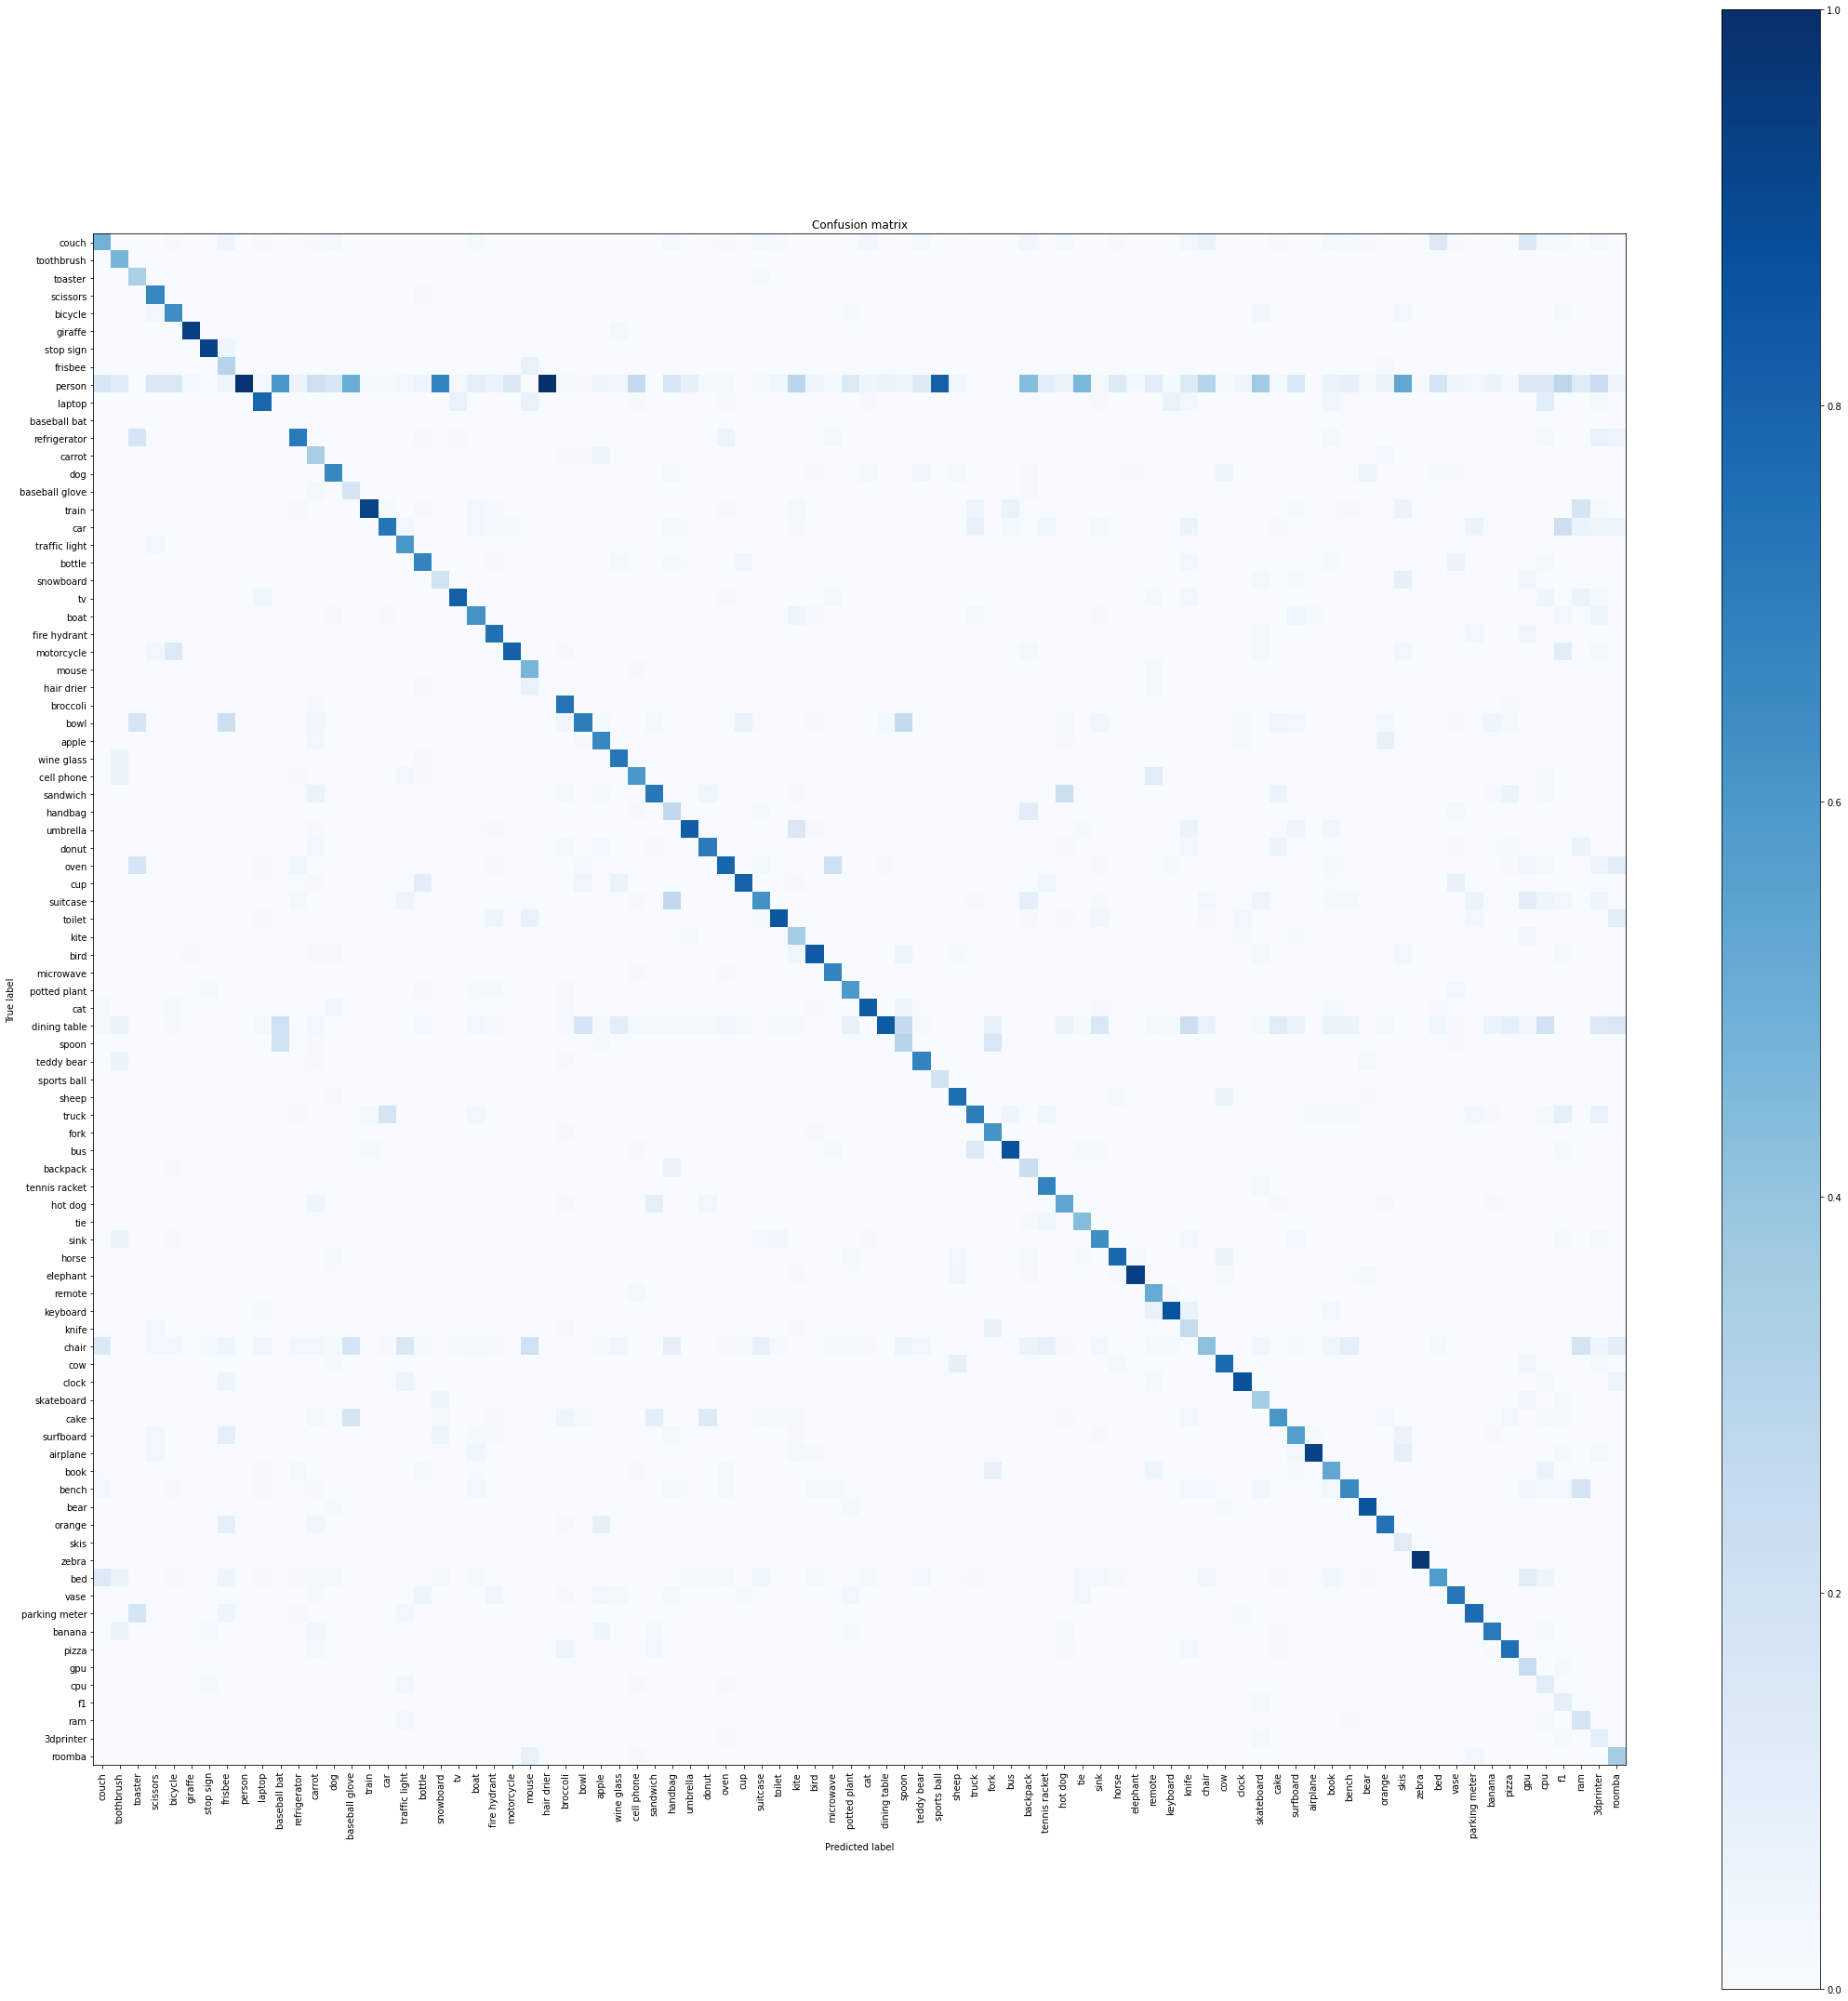

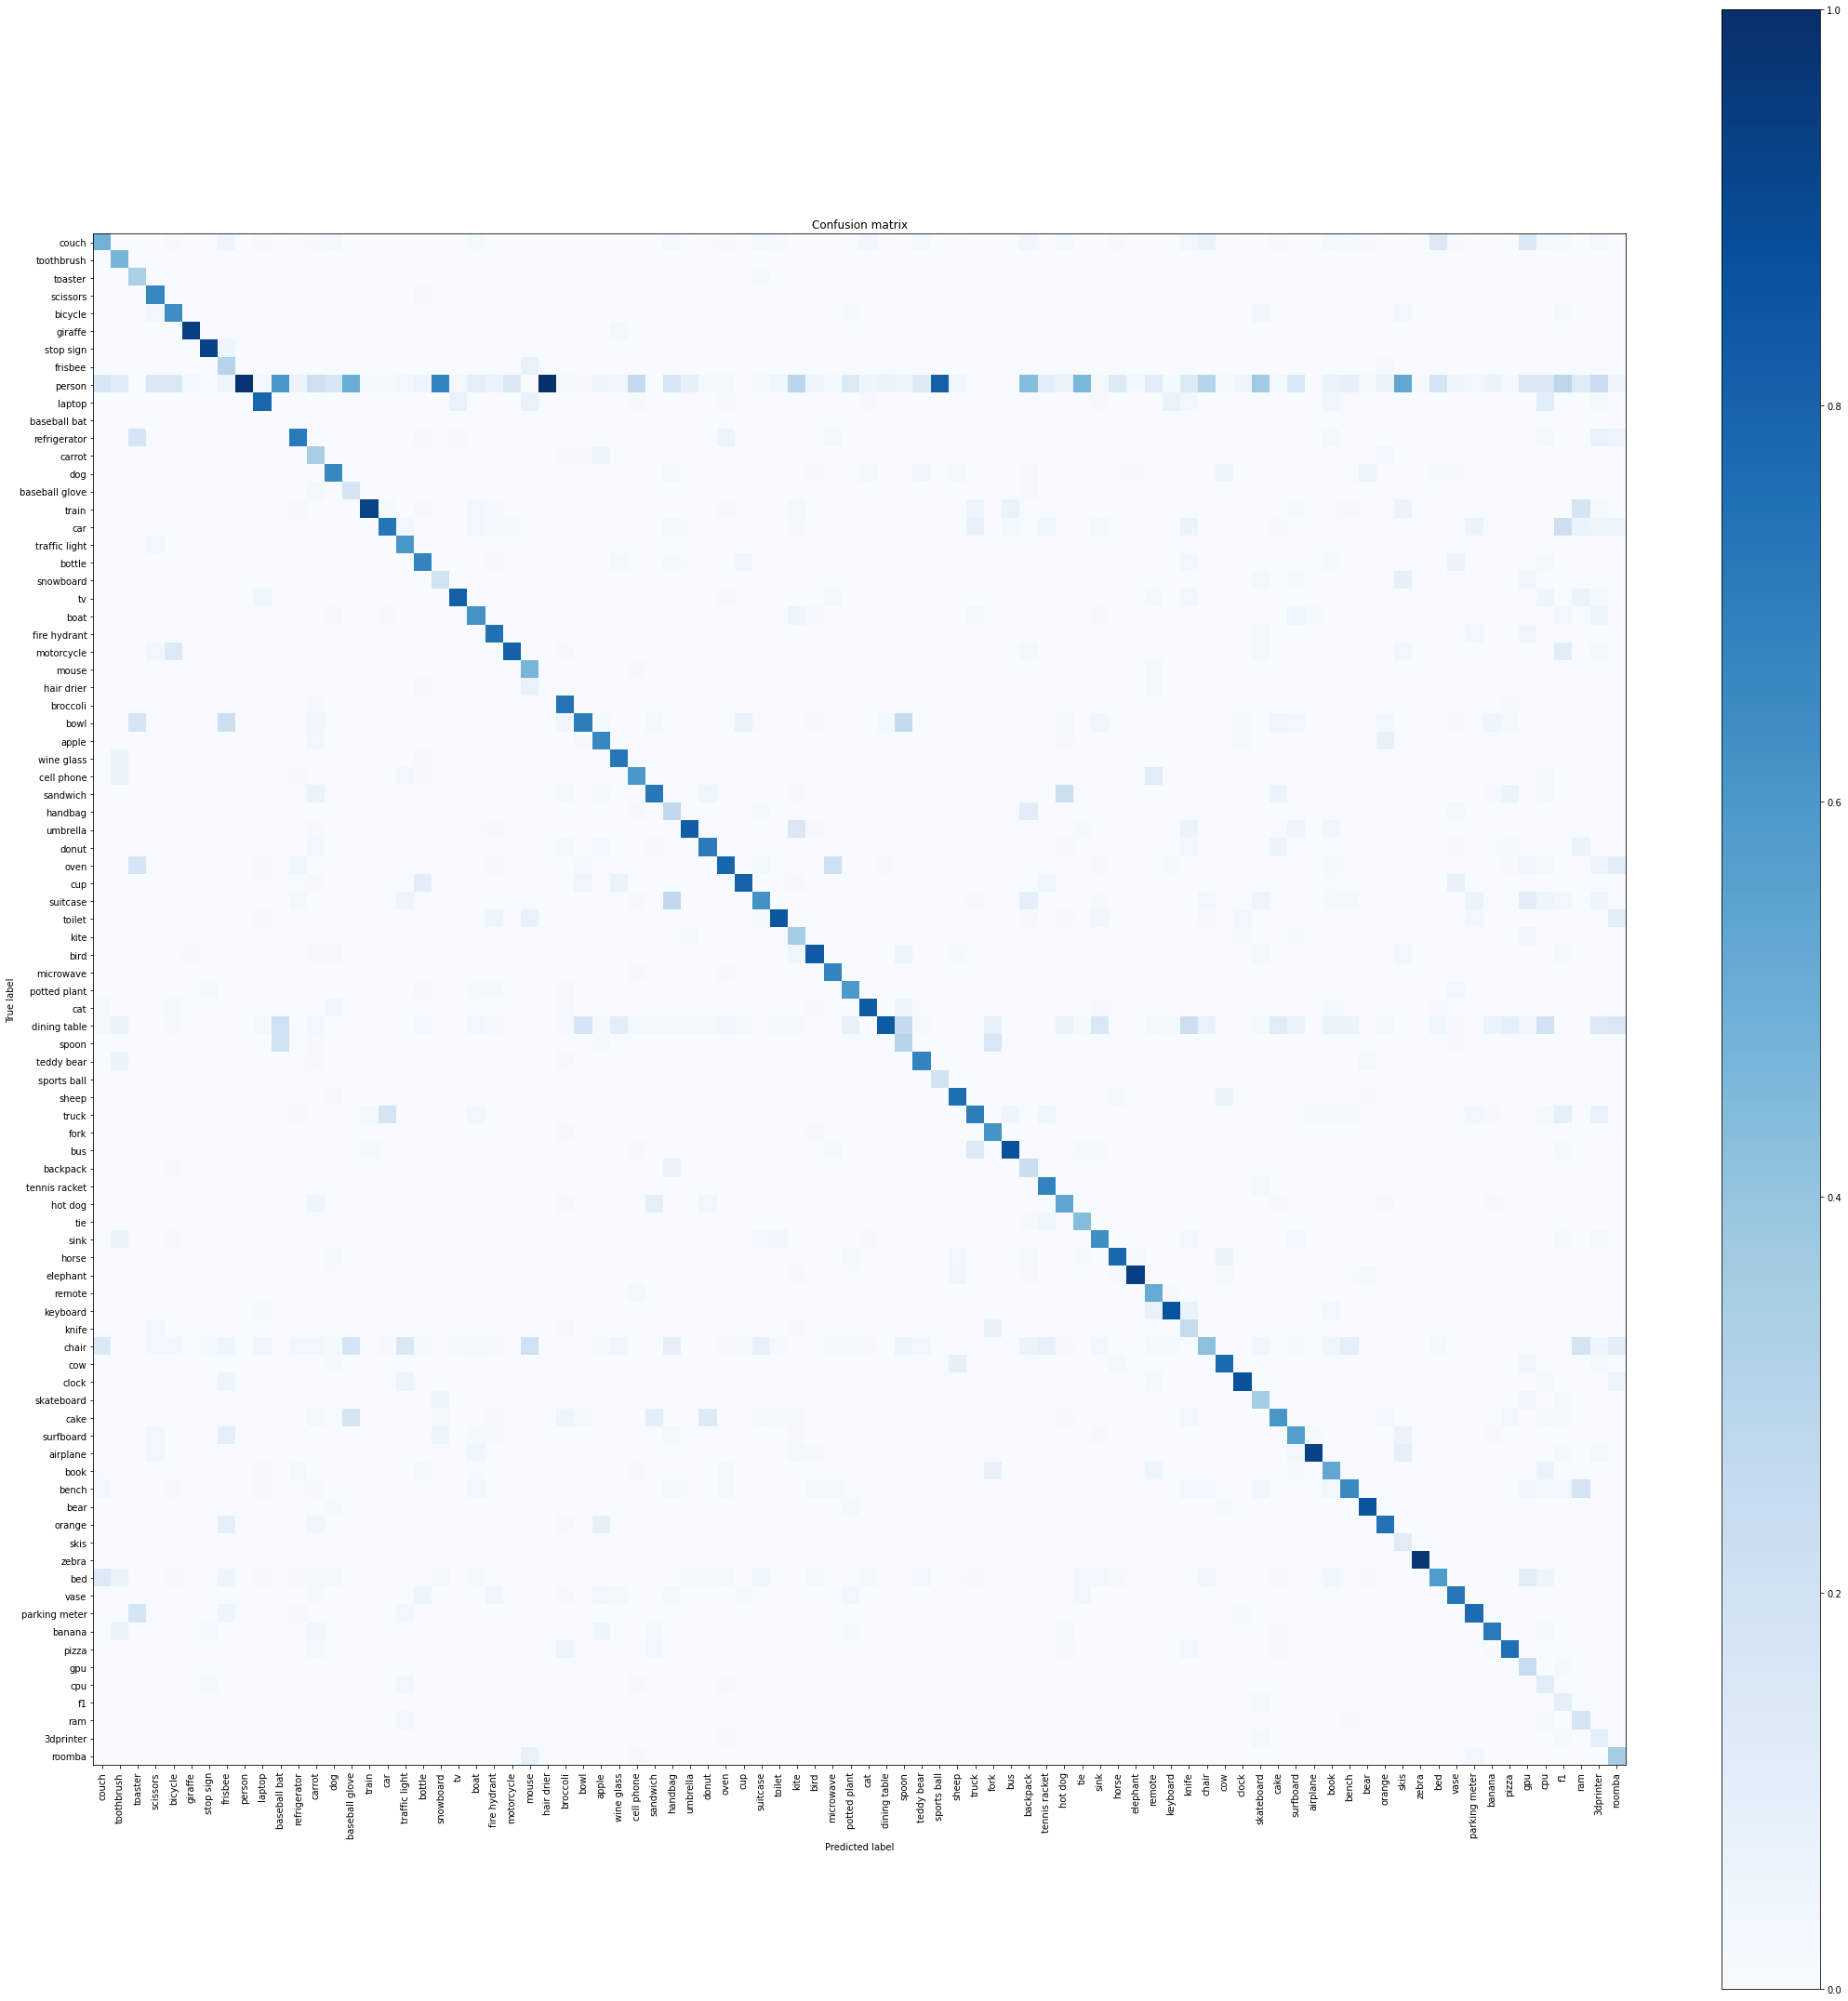

In [165]:
y = []
yhat = []

with open("logs/siamese_tripletloss/predictions_transfer_initial2.txt") as f:
    while True:
        line = f.readline()
        if line == "":
            break
        split = line.split(':')
        y.append(int(split[0]))
        yhat.append(int(split[1]))



cm = np.array(tf.math.confusion_matrix(np.array(y), np.array(yhat)))
cm = cm / cm.astype(np.float).sum(axis=0)
print(cm)

plot_confusion_matrix(cm, coco_labels_transfer, 'logs/siamese_tripletloss/siamese-confusionmatrix-transfer-initial.jpg')

In [166]:
tp = 0
fp = 0

for i in range(len(y)):
    if y[i] == yhat[i]:
        tp += 1
    else:
        fp += 1

print(f"True positives: {tp}, False positives: {fp}, Precision: {tp/(tp+fp)}")

True positives: 12415, False positives: 3649, Precision: 0.7728461155378487


In [151]:
data = get_training_triplets(include_transfer=True)
val_data = get_validation_triplets(include_transfer=True)

In [152]:
#freeze resnet50
resnet50.trainable = False

#compile again to reset optimizer

siamese_triplet_transfer = tf.keras.Model(inputs=inputs, outputs=outputs)

siamese_triplet_transfer.compile(
    optimizer=tf.keras.optimizers.Adam(0.00005),
    loss=tfa.losses.TripletHardLoss()
)

In [153]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/siamese_tripletloss

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/siamese_tripletloss/transfer-{0}'.format(current_time)
weight_dir = 'weights/siamese_tripletloss/transfer-{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=20)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

class ClusteringCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        results = embedding_model.predict(transfer_val_ds)
        np.savetxt(f"{log_dir}/vecs_{epoch}.tsv", results, delimiter='\t')

        out_m = io.open(f"{log_dir}/meta_{epoch}.tsv", "w", encoding="utf-8")
        for img, labels in tfds.as_numpy(transfer_val_ds):
            [out_m.write(str(x) + "\n") for x in labels]
        out_m.close()

clustering_callback = ClusteringCallback()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 318081), started 1 day, 0:50:56 ago. (Use '!kill 318081' to kill it.)

In [154]:
siamese_triplet_transfer.fit(data, validation_data=val_data, epochs=10, steps_per_epoch=100, batch_size=32, callbacks=[tensorboard_callback, weight_callback, clustering_callback])

Epoch 1/40
100/100 [==============================] - 834s 8s/step - loss: 0.3013 - model_loss: 0.1033 - model_1_loss: 0.0844 - model_2_loss: 0.1136 - val_loss: 0.5664 - val_model_loss: 0.2003 - val_model_1_loss: 0.1865 - val_model_2_loss: 0.1796
Epoch 2/40
100/100 [==============================] - 803s 8s/step - loss: 0.3276 - model_loss: 0.1131 - model_1_loss: 0.1038 - model_2_loss: 0.1108 - val_loss: 0.5632 - val_model_loss: 0.1986 - val_model_1_loss: 0.1854 - val_model_2_loss: 0.1791
Epoch 3/40
100/100 [==============================] - 807s 8s/step - loss: 0.2749 - model_loss: 0.1054 - model_1_loss: 0.0852 - model_2_loss: 0.0843 - val_loss: 0.5621 - val_model_loss: 0.1991 - val_model_1_loss: 0.1837 - val_model_2_loss: 0.1793
Epoch 4/40
100/100 [==============================] - 790s 8s/step - loss: 0.3104 - model_loss: 0.1136 - model_1_loss: 0.1039 - model_2_loss: 0.0929 - val_loss: 0.5550 - val_model_loss: 0.1955 - val_model_1_loss: 0.1813 - val_model_2_loss: 0.1782
Epoch 5/40
1

KeyboardInterrupt: 

In [155]:
transfer_anchor_averages = []
for i,c in enumerate(coco_labels_transfer):
    print(i)
    anchs = []

    for image in os.listdir(f'data/siamese_anchors_tripletloss_transfer/{c}'):
        img = load_image(f'data/siamese_anchors_tripletloss_transfer/{c}/{image}')
        anchs.append(img)

    preds = embedding_model.predict(np.array(anchs).reshape(len(anchs),224,224,3))
    transfer_anchor_averages.append(np.average(preds, axis=0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


In [158]:
iter = transfer_val_ds.as_numpy_iterator()

f = open("logs/siamese_tripletloss/predictions_transfer_finetuned.txt", "w")

for imgs,lbls in iter:
    preds = embedding_model.predict(imgs)

    for y,pred in enumerate(preds):
        distances = []
        for i,anchor in enumerate(transfer_anchor_averages):
            dist = distance.cosine(anchor, pred)
            distances.append(dist)

        guess = np.argmin(np.array(distances))
        f.write(f'{lbls[y]}:{guess}:{file}\n')

f.close()

/tmp/ipykernel_319120/1219184585.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=0)


[[0.47235023 0.         0.         ... 0.         0.         0.        ]
 [0.         0.8        0.         ... 0.         0.         0.        ]
 [0.         0.         0.28571429 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.5        0.         0.        ]
 [0.         0.         0.         ... 0.         0.29032258 0.        ]
 [0.         0.         0.         ... 0.         0.         0.64285714]]


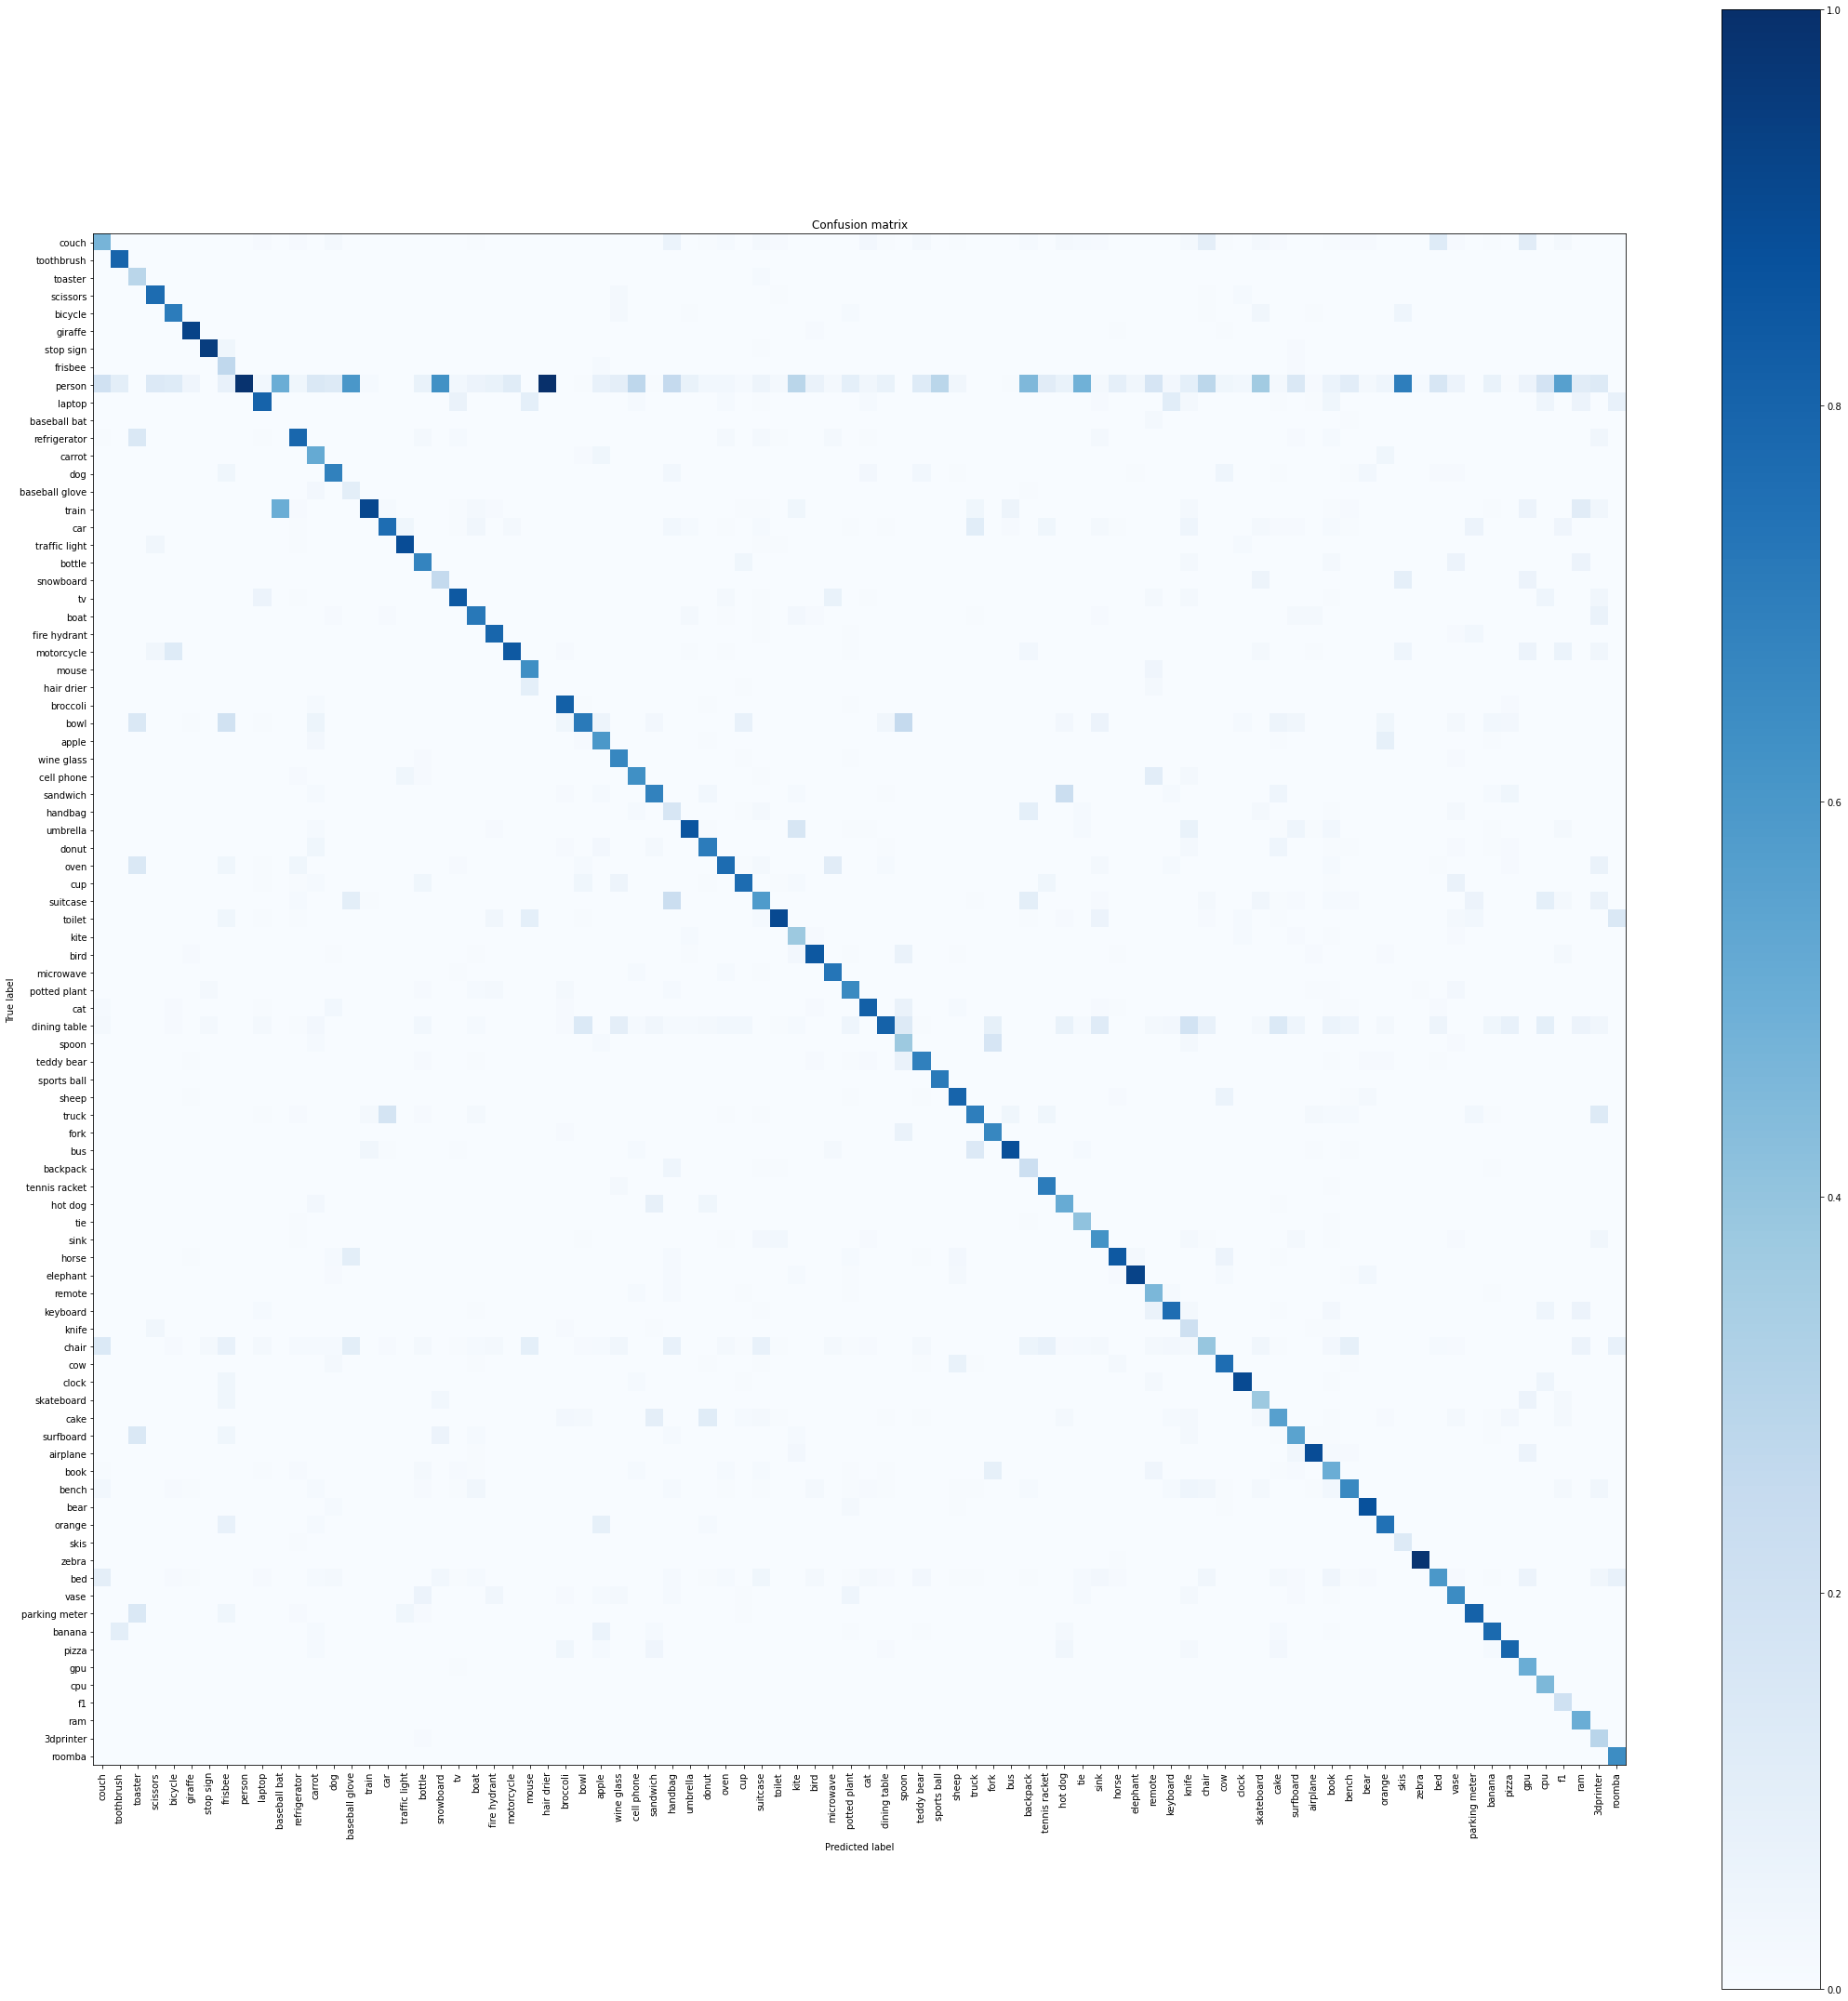

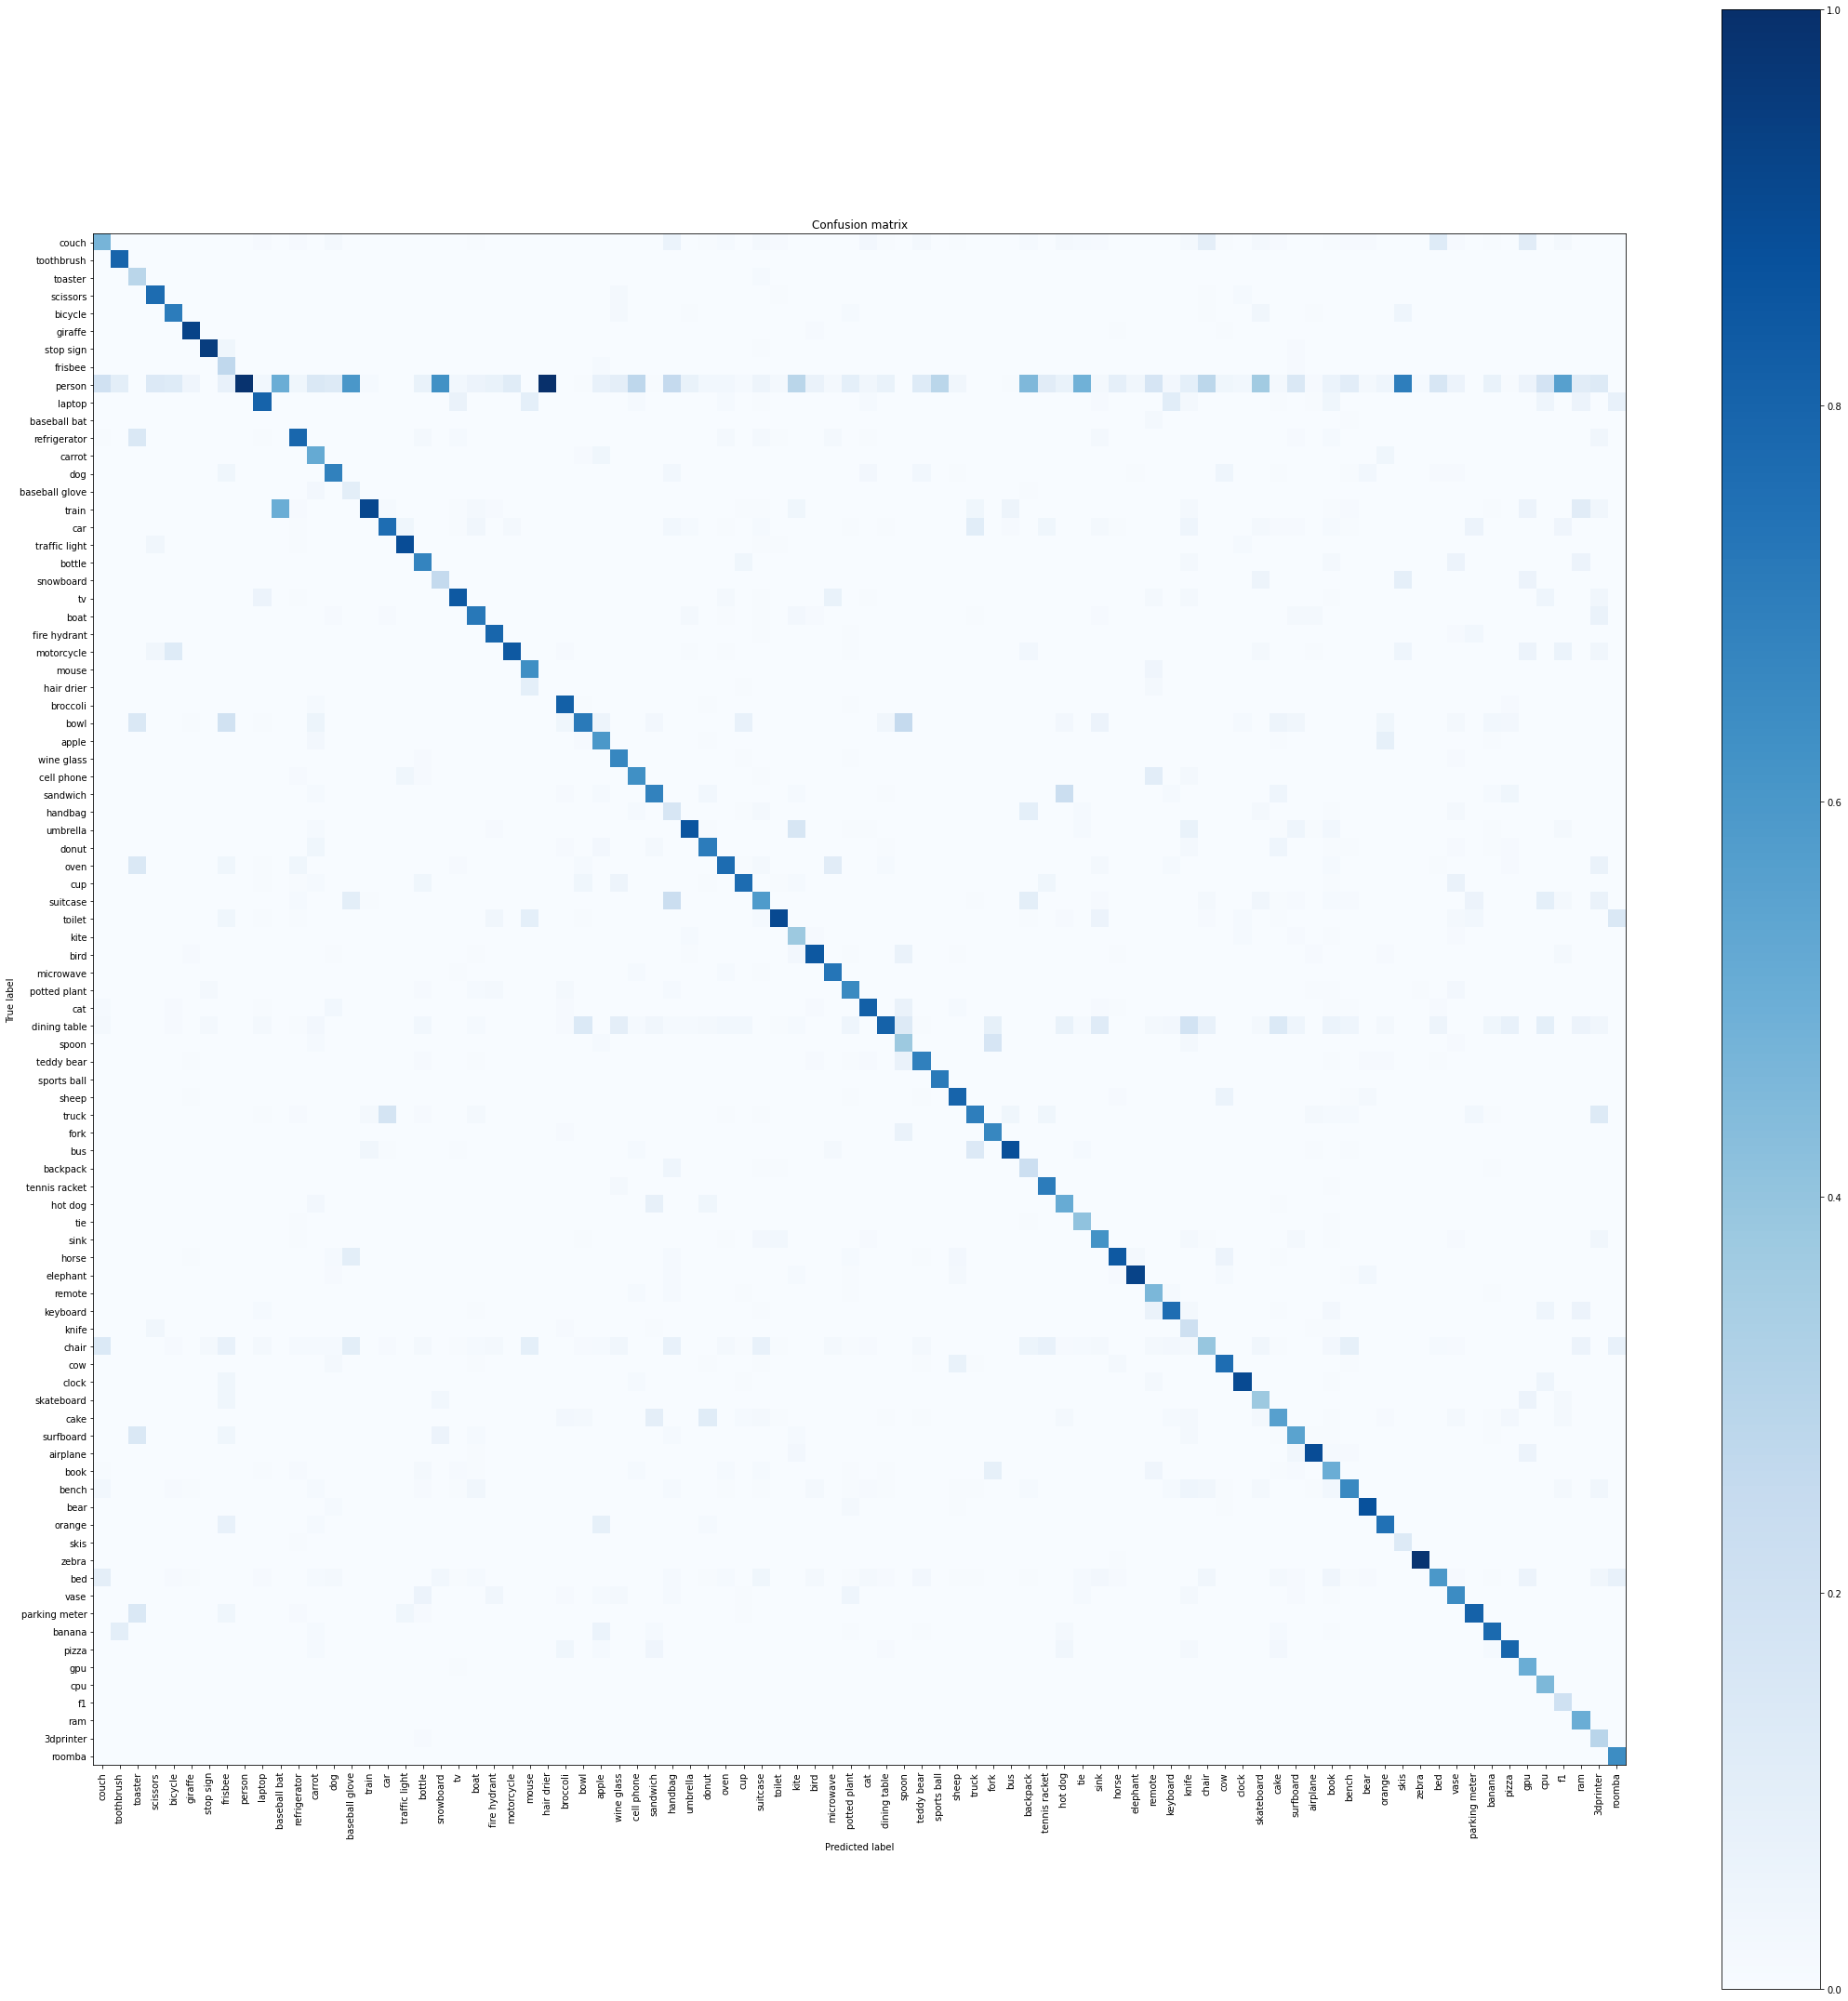

In [159]:
y = []
yhat = []

with open("logs/siamese_tripletloss/predictions_transfer_finetuned.txt") as f:
    while True:
        line = f.readline()
        if line == "":
            break
        split = line.split(':')
        y.append(int(split[0]))
        yhat.append(int(split[1]))



cm = np.array(tf.math.confusion_matrix(np.array(y), np.array(yhat)))
cm = cm / cm.astype(np.float).sum(axis=0)
print(cm)

plot_confusion_matrix(cm, coco_labels_transfer, 'logs/siamese_tripletloss/siamese-confusionmatrix-transfer-finetuned.jpg')

In [160]:
tp = 0
fp = 0

for i in range(len(y)):
    if y[i] == yhat[i]:
        tp += 1
    else:
        fp += 1

print(f"True positives: {tp}, False positives: {fp}, Precision: {tp/(tp+fp)}")

True positives: 12585, False positives: 3479, Precision: 0.7834287848605578


In [161]:
embedding_model.save(os.path.join(weight_dir, "final_embedding_transferred"))

INFO:tensorflow:Assets written to: weights/siamese_tripletloss/transfer-20220805-201928/final_embedding_transferred/assets
